In [1]:
from datetime import datetime
from finance_utils.backtest import Backtest
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

start_date = '1987-01-01'
end_date = '2024-08-10'
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

hsi = yf.download('^HSI', start=start_date, end=end_date)
nasdaq = yf.download('^IXIC', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
dow = pd.read_csv('/Users/henrywzh/Documents/data/^dji_d.csv')

dow = dow.iloc[927:]
dow['date'] = [i.replace('/', '-') for i in dow['Date']]
dow.set_index('date', inplace=True)
dow.index = pd.to_datetime(dow.index, format='%d-%m-%Y')
dow.drop(columns=['Date', 'Volume'], inplace=True)
dow.index.name = 'Date'
dow = dow[(dow.index >= start_date) & (dow.index <= end_date)]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [2]:
global_index = pd.merge(dow['Close'], sp500['Close'], left_index=True, right_index=True).rename(columns={'Close_x': 'dow', 'Close_y': 'sp500'})
global_index = pd.merge(global_index, nasdaq['Close'], left_index=True, right_index=True).rename(columns={'Close': 'nasdaq'})
global_index = pd.merge(global_index, hsi['Close'], left_index=True, right_index=True).rename(columns={'Close': 'hsi'})
global_index = global_index / global_index.iloc[0]

In [3]:
def rolling_corr(rolling_days = 120, target = 'sp500', check = 'all'):
    global_corr = global_index.rolling(rolling_days).corr().dropna().reset_index()
    global_indexes = ['dow', 'sp500', 'nasdaq', 'hsi']
    
    if check != 'all':
        index = check
        plt.figure(figsize=(10, 6))
        plt.plot(global_corr[global_corr['level_1'] == target]['Date'], global_corr[global_corr['level_1'] == target][index])
        plt.title(f'{index} {rolling_days} rolling days correlation with {target}')
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.show()
        
        return
        
    for index in global_indexes:
        if index == target:
            continue
        
        plt.figure(figsize=(10, 6))
        plt.plot(global_corr[global_corr['level_1'] == target]['Date'], global_corr[global_corr['level_1'] == target][index])
        plt.title(f'{index} {rolling_days} rolling days correlation with {target}')
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.show()

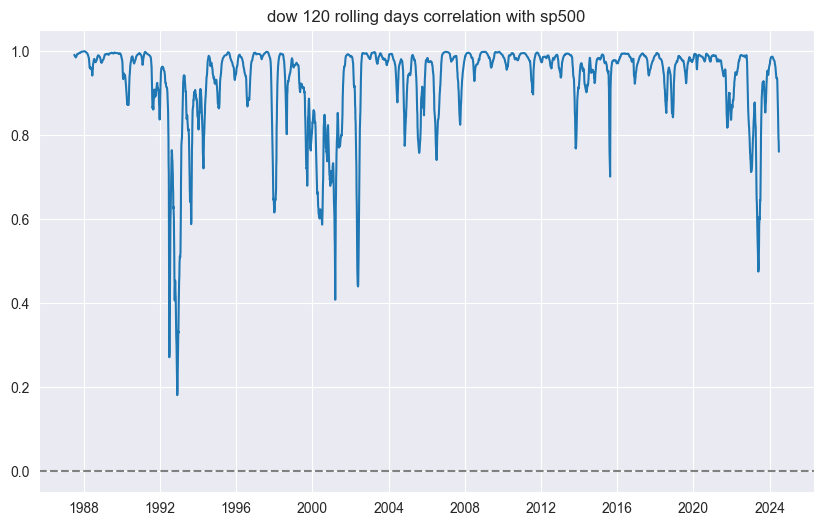

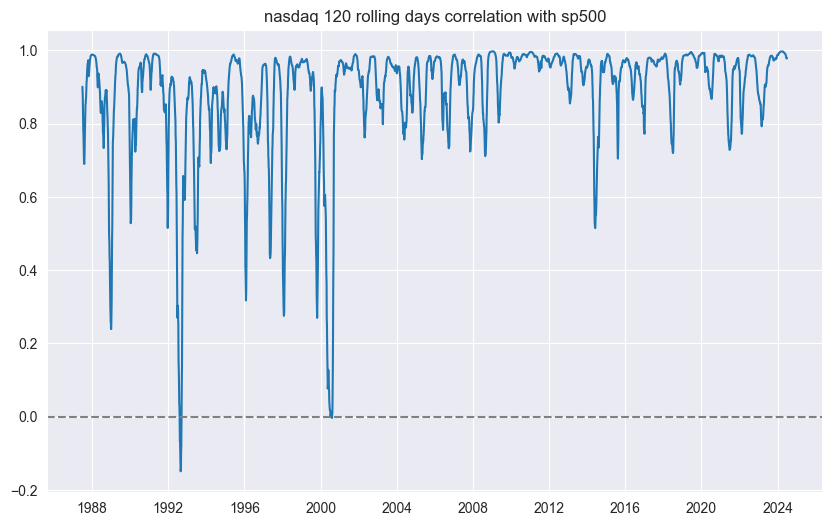

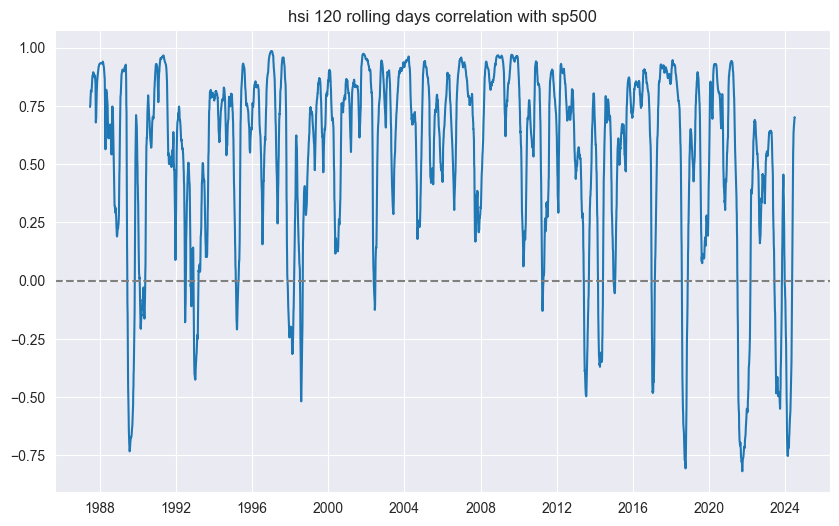

In [4]:
# for i in range(60, 250, 20):
#     rolling_corr(i, check='hsi')

rolling_corr(120)

Hang Seng Index / SP500 Ratio:
- Check for relative market performance
- High ratio represents better market performance in HK

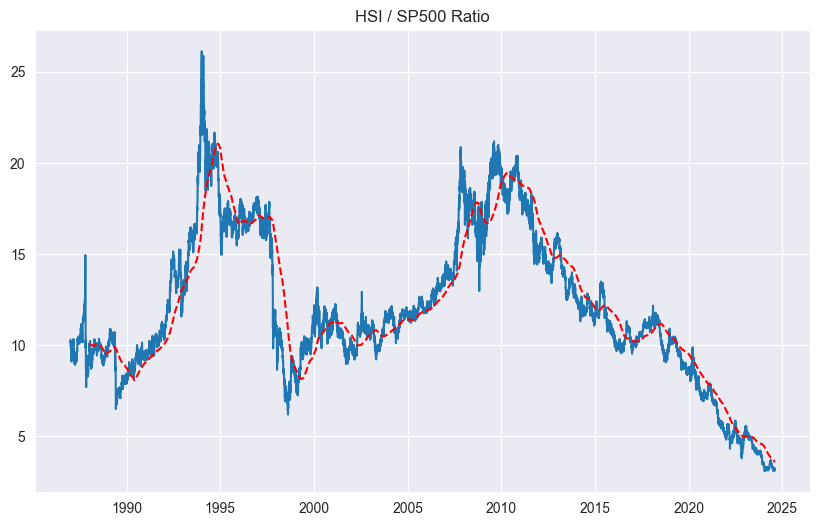

In [6]:
plt.figure(figsize=(10, 6))
ratio = (hsi['Adj Close'] / sp500['Adj Close']).dropna()
plt.plot(ratio)
plt.plot(ratio.rolling(250).mean(), color='red', linestyle='--')
plt.title(f'HSI / SP500 Ratio')
plt.show()

Nasdaq / Dow Ratio:
- Check for market momentum
- High ratio tends to represent bullish market
- Low ratio tends to represent bearish market

In [7]:
start_date = '1970-01-01'
nasdaq = yf.download('^IXIC', start=start_date)
start_date = nasdaq.index[0]
dow = pd.read_csv('/Users/henrywzh/Documents/data/^dji_d.csv')

dow = dow.iloc[927:]
dow['date'] = [i.replace('/', '-') for i in dow['Date']]
dow.set_index('date', inplace=True)
dow.index = pd.to_datetime(dow.index, format='%d-%m-%Y')
dow.drop(columns=['Date', 'Volume'], inplace=True)
dow.index.name = 'Date'
dow = dow[dow.index >= start_date]

[*********************100%%**********************]  1 of 1 completed


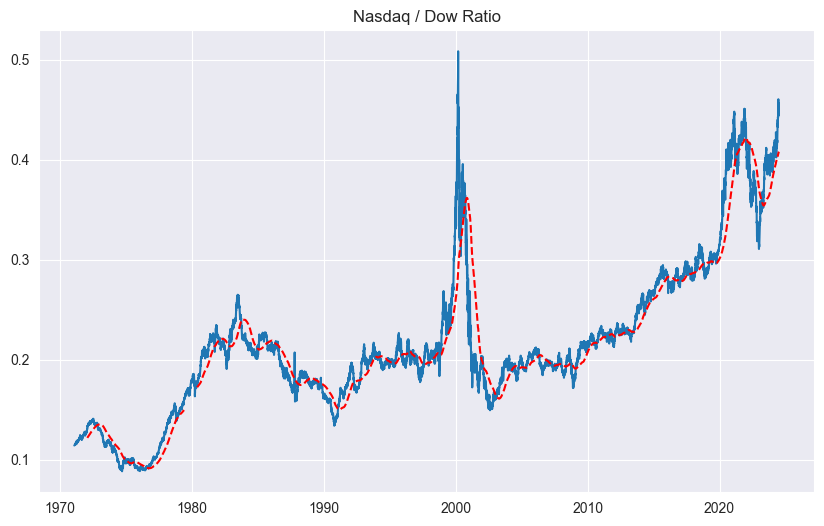

In [10]:
plt.figure(figsize=(10, 6))
ratio = nasdaq['Adj Close'] / dow['Close']
plt.plot(ratio)
plt.plot(ratio.rolling(250).mean(), color='red', linestyle='--')
plt.title('Nasdaq / Dow Ratio')
plt.show()

In [17]:
bonds = pd.read_csv('/Users/henrywzh/Documents/data/bond_index.csv')
stocks = yf.download('SPY', start='2011-09-01', interval='1mo')

bonds['Year'] = [int(s.split('/')[1]) for s in bonds['Date'].tolist()]
bonds['Month'] = [int(s.split('/')[0]) for s in bonds['Date'].tolist()]
dates = [f"{bonds['Year'].iloc[i]}-{bonds['Month'].iloc[i]}-01" for i in range(bonds.shape[0])]
bonds.index = pd.to_datetime(dates)
stocks['Year'] = stocks.index.year
stocks['Month'] = stocks.index.month

sixty_forty = pd.merge(stocks[['Year', 'Month', 'Adj Close']], bonds[['Year', 'Month', 'Bloomberg US Aggregate Bond']], on=['Year', 'Month'])
sixty_forty.index = bonds.index
sixty_forty.rename(columns={'Adj Close': 'SP500'}, inplace=True)
sixty_forty['SP500 Return'] = sixty_forty['SP500'].pct_change().dropna()
sixty_forty['Bond Return'] = sixty_forty['Bloomberg US Aggregate Bond'].pct_change().dropna()
sixty_forty['SP500 Std'] = sixty_forty['SP500 Return'].rolling(30).std()
sixty_forty['Bond Std'] = sixty_forty['Bond Return'].rolling(30).std()
sixty_forty

[*********************100%%**********************]  1 of 1 completed


,Year,Month,SP500,Bloomberg US Aggregate Bond,SP500 Return,Bond Return,SP500 Std,Bond Std
2011-09-01,2011,9,88.961937,10000.000000,NaN,NaN,NaN,NaN
2011-10-01,2011,10,99.182373,9923.279076,0.114885,-0.007672,NaN,NaN
2011-11-01,2011,11,98.779327,10002.064454,-0.004064,0.007939,NaN,NaN
2011-12-01,2011,12,99.182373,10111.999062,0.004080,0.010991,NaN,NaN
2012-01-01,2012,1,104.440109,10200.746041,0.053011,0.008776,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-01,2024,3,519.773010,12196.646980,0.029503,0.009234,0.054903,0.022617
2024-04-01,2024,4,500.365784,11888.578047,-0.037338,-0.025258,0.054158,0.022976
2024-05-01,2024,5,525.674133,12090.128190,0.050580,0.016953,0.054702,0.023256
2024-06-01,2024,6,542.469910,12204.588938,0.031951,0.009467,0.054502,0.023371


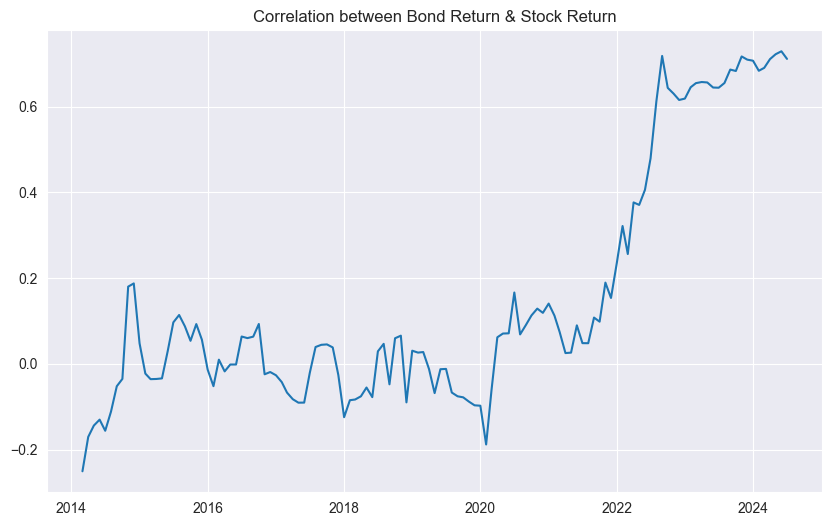

In [34]:
corrs = sixty_forty[['SP500 Return', 'Bond Return']].rolling(30).corr().dropna().reset_index()[['level_0', 'SP500 Return']]
corrs.set_index('level_0', inplace=True)
corrs = corrs[corrs < 0.9999].dropna()

plt.figure(figsize=(10, 6))
plt.plot(corrs)
plt.title('Correlation between Bond Return & Stock Return')
plt.show()

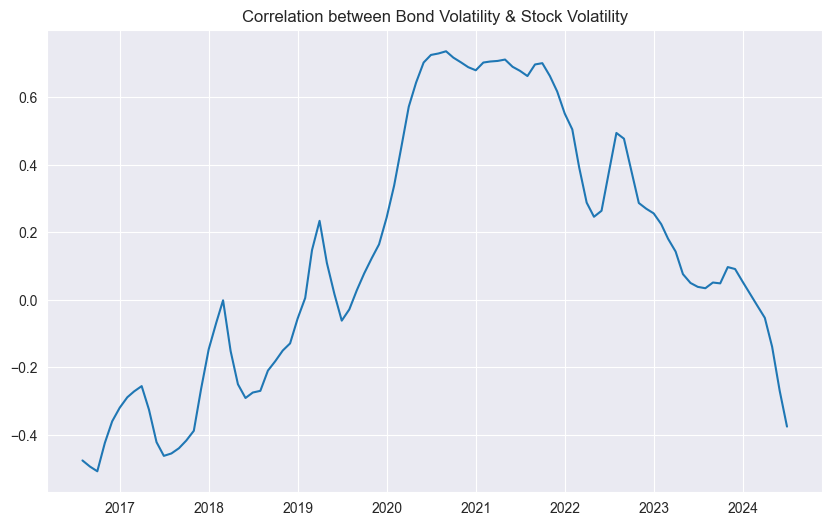

In [35]:
corrs = sixty_forty[['SP500 Std', 'Bond Std']].rolling(30).corr().dropna().reset_index()[['level_0', 'SP500 Std']]
corrs.set_index('level_0', inplace=True)
corrs = corrs[corrs < 0.9999].dropna()

plt.figure(figsize=(10, 6))
plt.plot(corrs)
plt.title('Correlation between Bond Volatility & Stock Volatility')
plt.show()

Invest by PE ratio
- buy when PE ratio is low
- sell when PE ratio is high
- can use technical indicators to define high-low